In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
!pip install POT
!pip install torchmetrics

100%|██████████| 112/112 [00:00<00:00, 221.70it/s]


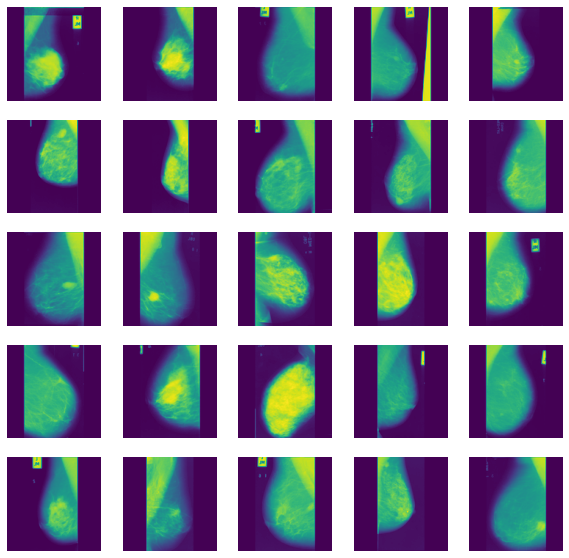

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
PIC_DIR = '/content/drive/My Drive/LOP_DATASET/train/B/'
IMAGES_COUNT = 150
ORIG_WIDTH = 128
ORIG_HEIGHT = 128
#diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
#WIDTH = 0
#HEIGHT = 0
diff = 0
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file)
    pic.thumbnail((ORIG_WIDTH, ORIG_HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
LATENT_DIM = 32
CHANNELS = 1
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [ ]:
from keras import backend as K
K.image_data_format()

'channels_last'

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(ORIG_HEIGHT, ORIG_WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator


In [ ]:
import math
import os
import timeit
import math

import numpy as np
import ot
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import pdb
from tqdm import tqdm

from scipy.stats import entropy
from numpy.linalg import norm
from scipy import linalg


def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)


def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        # folder dataset
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset


def sampleFake(netG, nz, sampleSize, batchSize, saveFolder):
    print('sampling fake images ...')
    saveFolder = saveFolder + '0/'

    try:
        os.makedirs(saveFolder)
    except OSError:
        pass

    noise = torch.FloatTensor(batchSize, nz, 1, 1).cuda()
    iter = 0
    for i in range(0, 1 + sampleSize // batchSize):
        noise.data.normal_(0, 1)
        fake = netG(noise)
        for j in range(0, len(fake.data)):
            if iter < sampleSize:
                vutils.save_image(fake.data[j].mul(0.5).add(
                    0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break


def sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize, saveFolder, workers=4):
    print('sampling real images ...')
    saveFolder = saveFolder + '0/'

    dataset = make_dataset(dataset, dataroot, imageSize)
    dataloader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))

    if not os.path.exists(saveFolder):
        try:
            os.makedirs(saveFolder)
        except OSError:
            pass

    iter = 0
    for i, data in enumerate(dataloader, 0):
        img, _ = data
        for j in range(0, len(img)):

            vutils.save_image(img[j].mul(0.5).add(
                0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break
        if iter >= sampleSize:
            break



class ConvNetFeatureSaver(object):
    def __init__(self, model='resnet34', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, save2disk=False):
        dataset = dset.ImageFolder(root=imgFolder, transform=self.trans)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, num_workers=self.workers)
        print('extracting features...')
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []
        for img, _ in tqdm(dataloader):
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'vgg' or self.model == 'vgg16':
                    fconv = self.vgg.features(input).view(input.size(0), -1)
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        if save2disk:
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_pixl.pth'))
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_conv.pth'))
            torch.save(feature_logit, os.path.join(
                imgFolder, 'feature_logit.pth'))
            torch.save(feature_smax, os.path.join(
                imgFolder, 'feature_smax.pth'))

        return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_real = s.tp / (s.tp + s.fn)
    s.acc_fake = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k
    print("Prcision:", s.precision, "Recall:", s.recall, "Accuracy:", s.acc)
    print("\n")
    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())
    print("\nMMD Score:",mmd)
    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))
    print("\nEntropy Score:",scores)
    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem*torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e



eps = 1e-20
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())
    print("\nInception Score:", score)
    return score

def mode_score(X, Y):
    kl1 = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0)+eps).log()-(Y.mean(0)+eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())
    print("\n Mode Score:", score)
    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
        np.trace(C + C_w - 2 * C_C_w_sqrt)
    print("\nFID:", np.sqrt(score))
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


def compute_score_raw(batchSize, conv_model='resnet34', workers=4):

   # sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize,
              # saveFolder_r, workers=workers)
   # sampleFake(netG, nz, sampleSize, batchSize, saveFolder_f, )
    saveFolder_f = '/content/drive/My Drive/GAN/fake/';
    saveFolder_r = '/content/drive/My Drive/LOP_DATASET/train/'; 
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,batchSize=batchSize, workers=workers)
    feature_r = convnet_feature_saver.save(saveFolder_r)
    feature_f = convnet_feature_saver.save(saveFolder_f)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(4 * 7 + 3)
    for i in range(0, 4):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_real, tmp.acc_fake, tmp.precision, tmp.recall

    score[28] = inception_score(feature_f[3])
    score[29] = mode_score(feature_r[3], feature_f[3])
    score[30] = fid(feature_r[3], feature_f[3])
    return score

In [ ]:
'''import math
import os
import timeit
import math
import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import pdb
from tqdm import tqdm

from scipy.stats import entropy
from numpy.linalg import norm
from scipy import linalg
import torch
import torchmetrics
from torchmetrics import ROC
from torchmetrics import PrecisionRecallCurve

def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M




class Score_knn:
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0


def knn(Mxx, Mxy, Myy, k, sqrt,epoch):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    #print("label",label)
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()
    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    print("\n Avg Precision:",s.precision,"Recall:",s.recall,"for epoch:",epoch)
    print("\n Avg TP:", s.tp, "Avg FP:", s.fp, "Avg FN:", s.fn, "Avg TN:", s.fn)
    #print("Pred:",pred)
    y_pred = torch.sigmoid(pred)
    #print("NEW PRED",y_pred)
    pr_curve = PrecisionRecallCurve(pos_label=1)
    precision, recall, thresholds = pr_curve(y_pred, label)
    
    roc = ROC(pos_label=1)
    fpr, tpr, thresholds = roc(y_pred, label) 
    
    return precision,recall,fpr,tpr



eps = 1e-20
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())
    print("Inception Score:",score)
    return score


class Score:
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s
'''

'import math\nimport os\nimport timeit\nimport math\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport ot\nimport torch\nfrom torch import nn\nimport torch.nn.functional as F\nimport torchvision.datasets as dset\nimport torchvision.transforms as transforms\nimport torchvision.utils as vutils\nimport torchvision.models as models\nimport pdb\nfrom tqdm import tqdm\n\nfrom scipy.stats import entropy\nfrom numpy.linalg import norm\nfrom scipy import linalg\nimport torch\nimport torchmetrics\nfrom torchmetrics import ROC\nfrom torchmetrics import PrecisionRecallCurve\n\ndef distance(X, Y, sqrt):\n    nX = X.size(0)\n    nY = Y.size(0)\n    X = X.view(nX,-1)\n    X2 = (X*X).sum(1).resize_(nX,1)\n    Y = Y.view(nY,-1)\n    Y2 = (Y*Y).sum(1).resize_(nY,1)\n\n    M = torch.zeros(nX, nY)\n    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -\n            2 * torch.mm(X, Y.transpose(0, 1)))\n\n    del X, X2, Y, Y2\n\n    if sqrt:\n        M = ((M + M.abs()) / 2).sqrt()\n\n

In [ ]:
'''import torchvision

class ConvNetFeatureSaver(object):
    def __init__(self, model='inception_v3', workers=4, batchSize=64):
        
        self.model = model
        self.batch_size = batchSize
        self.workers = workers

        if self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, save2disk=False):
      split_dir, bshuffle = 'train', True
      #print("0")
    # Get data loader
      saveFolder = '/content/drive/My Drive/GAN/Feature Metrics'
     # imsize = BASE_SIZE * (2 ** (BRANCH_NUM - 1));
      transform = transforms.Compose([transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor()])
      dataset = torchvision.datasets.ImageFolder(imgFolder, transform=transform);
      assert dataset;
     
      dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=4,
            shuffle=True, num_workers=self.workers);
     
      #print('extracting features...')
      feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []
      #print(type(dataloader))
      for img, _ in tqdm(dataloader):
        with torch.no_grad():
          input = img.cuda()
              
          if self.model == 'inception' or self.model == 'inception_v3':

            fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
            flogit = self.inception.fc(fconv)
          else:
            raise NotImplementedError
          fsmax = F.softmax(flogit)
          feature_pixl.append(img)
          feature_conv.append(fconv.data.cpu())
          feature_logit.append(flogit.data.cpu())
          feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        if save2disk:
            torch.save(feature_conv, os.path.join(
                saveFolder, 'feature_pixl.pth'))
            torch.save(feature_conv, os.path.join(
                saveFolder, 'feature_conv.pth'))
            torch.save(feature_logit, os.path.join(
                saveFolder, 'feature_logit.pth'))
            torch.save(feature_smax, os.path.join(
                saveFolder, 'feature_smax.pth'))

        return feature_pixl, feature_conv, feature_logit, feature_smax'''

'import torchvision\n\nclass ConvNetFeatureSaver(object):\n    def __init__(self, model=\'inception_v3\', workers=4, batchSize=64):\n        \n        self.model = model\n        self.batch_size = batchSize\n        self.workers = workers\n\n        if self.model == \'inception\' or self.model == \'inception_v3\':\n            inception = models.inception_v3(\n                pretrained=True, transform_input=False).cuda().eval()\n            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,\n                                              inception.Conv2d_2a_3x3,\n                                              inception.Conv2d_2b_3x3,\n                                              nn.MaxPool2d(3, 2),\n                                              inception.Conv2d_3b_1x1,\n                                              inception.Conv2d_4a_3x3,\n                                              nn.MaxPool2d(3, 2),\n                                              inception.Mixed_5b,\n     

In [ ]:
'''def metric_scores():
  
  fscore = []
  pre = []
  re = []
  TP = []
  FP = []
  convnet_feature_saver = ConvNetFeatureSaver(model='inception_v3',
                                                batchSize=64, workers=4);
    
  saveFolder_f = '/content/drive/My Drive/GAN/fake/';
  saveFolder_r = '/content/drive/My Drive/LOP_DATASET/train/';
  
  for epoch in range(5):
    print("Epoch No:",epoch)
    feature_r = convnet_feature_saver.save(saveFolder_r);
    print("loaded real images")
    feature_f = convnet_feature_saver.save(saveFolder_f);
    print("loaded fake images")
    fscore.append(inception_score(feature_f[3]))
    Mxx = distance(feature_r[1], feature_r[1], False)
    Mxy = distance(feature_r[1], feature_f[1], False)
    Myy = distance(feature_f[1], feature_f[1], False)
    precision,recall,tp,fp = knn(Mxx, Mxy, Myy, 1, False,epoch)
    pre.append(precision)
    re.append(recall)
    TP.append(tp)
    FP.append(fp)
  return fscore,pre,re,TP,FP '''

'def metric_scores():\n  \n  fscore = []\n  pre = []\n  re = []\n  TP = []\n  FP = []\n  convnet_feature_saver = ConvNetFeatureSaver(model=\'inception_v3\',\n                                                batchSize=64, workers=4);\n    \n  saveFolder_f = \'/content/drive/My Drive/GAN/fake/\';\n  saveFolder_r = \'/content/drive/My Drive/LOP_DATASET/train/\';\n  \n  for epoch in range(5):\n    print("Epoch No:",epoch)\n    feature_r = convnet_feature_saver.save(saveFolder_r);\n    print("loaded real images")\n    feature_f = convnet_feature_saver.save(saveFolder_f);\n    print("loaded fake images")\n    fscore.append(inception_score(feature_f[3]))\n    Mxx = distance(feature_r[1], feature_r[1], False)\n    Mxy = distance(feature_r[1], feature_f[1], False)\n    Myy = distance(feature_f[1], feature_f[1], False)\n    precision,recall,tp,fp = knn(Mxx, Mxy, Myy, 1, False,epoch)\n    pre.append(precision)\n    re.append(recall)\n    TP.append(tp)\n    FP.append(fp)\n  return fscore,pre,re,TP,

In [ ]:
#fs,p,r,tps,fps = metric_scores()


In [ ]:
'''for i in range(5):
 
    plt.plot(fps[i], tps[i], color='b', label='ROC')
    plt.plot(r[i],p[i],color = 'g', label = 'Precision-Recall Curve')
    plt.title('ROC and Precision-Recall curve')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
'''

"for i in range(5):\n \n    plt.plot(fps[i], tps[i], color='b', label='ROC')\n    plt.plot(r[i],p[i],color = 'g', label = 'Precision-Recall Curve')\n    plt.title('ROC and Precision-Recall curve')\n    plt.xlim([0, 1])\n    plt.ylim([0, 1])\n    plt.legend()\n    plt.show()\n"

In [ ]:
#LATENT_DIM = 512
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
g = generator(gan_input)
gan_output = discriminator(g)
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import time
iters = 500
batch_size = 4

RES_DIR = '/content/drive/My Drive/GAN/O/OUTPUTR'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
outf = '/content/drive/My Drive/GAN/METRICS'
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
score_tr = np.zeros((iters, 4*7+3))

# compute initial score
#s = compute_score_raw(16,conv_model='inception_v3', workers=int(2))
#score_tr[0] = s
#np.save('%s/score_tr.npy' % (outf), score_tr)

for step in range(iters):
    print("\nEPOCH:",step)
    start_time = time.time()
    print("\n TIME:", start_time)
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    generated = np.squeeze(generated)
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    #print("\nlabels",labels)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    #print("\nD LOSS:",d_losses)
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    #if step % 5 == 0:
    gan.save_weights('/content/drive/My Drive/gan.h5')

    print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
    control_image = np.zeros((ORIG_WIDTH * CONTROL_SIZE_SQRT, ORIG_HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
    control_generated = generator.predict(control_vectors)
    control_generated = control_generated[0,:,:,:]
    control_generated = np.squeeze(control_generated)
        #for i in range(2):
         #   x_off = i % CONTROL_SIZE_SQRT
          #  y_off = i // CONTROL_SIZE_SQRT
           # control_image[x_off * ORIG_WIDTH:(x_off + 1) * ORIG_WIDTH, y_off * ORIG_HEIGHT:(y_off + 1) * ORIG_HEIGHT, :] = control_generated[i, :, :, :]
        #im = Image.fromarray(np.uint8(control_image * 255))
    im = Image.fromarray((control_generated * 255).astype(np.uint8))
    print("\nShape:",im.size)
    im.save(FILE_PATH % (RES_DIR, images_saved))
    images_saved += 1

            ################################################
        #### metric scores computing (key function) ####
        ################################################
    s = compute_score_raw(16, conv_model='inception_v3', workers=int(2))
    score_tr[step] = s


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/content/drive/My Drive/visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

# save final metric scores of all epoches
np.save('%s/score_tr_ep.npy' % outf, score_tr)
print('##### training completed :) #####')
print('### metric scores output is scored at %s/score_tr_ep.npy ###' % outf)


EPOCH: 0

 TIME: 1635927096.6950548
1/500: d_loss: 0.6938,  a_loss: 0.6928.  (50.1 sec)

Shape: (128, 128)
extracting features...


100%|██████████| 18/18 [00:05<00:00,  3.34it/s]


extracting features...


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


compute score in space: 0

MMD Score: 0.696365673243072
Prcision: tensor(0.9965) Recall: tensor(1.) Accuracy: tensor(0.9965)


compute score in space: 1


RuntimeError: ignored

In [ ]:
s = compute_score_raw(16, conv_model='inception_v3', workers=int(2))
score_tr[0] = s

extracting features...


100%|██████████| 18/18 [00:05<00:00,  3.51it/s]


extracting features...


100%|██████████| 38/38 [00:58<00:00,  1.55s/it]


compute score in space: 0

MMD Score: 0.405632062594817
Prcision: tensor(0.9929) Recall: tensor(0.9860) Accuracy: tensor(0.9932)


compute score in space: 1

MMD Score: 0.5232931478929801
Prcision: tensor(1.) Recall: tensor(1.) Accuracy: tensor(1.)


compute score in space: 2

MMD Score: 0.521441968700945
Prcision: tensor(1.) Recall: tensor(1.) Accuracy: tensor(1.)


compute score in space: 3

MMD Score: 0.22499012395588733
Prcision: tensor(0.9371) Recall: tensor(0.9404) Accuracy: tensor(0.9605)



Inception Score: tensor(1.4026)

 Mode Score: tensor(1.0676)

FID: tensor(0.0805)


In [ ]:
# save final metric scores of all epoches
np.save('%s/score_tr_ep.npy' % outf, score_tr)
print('##### training completed :) #####')
print('### metric scores output is scored at %s/score_tr_ep.npy ###' % outf)

##### training completed :) #####
### metric scores output is scored at /content/drive/My Drive/GAN/METRICS/score_tr_ep.npy ###


In [ ]:
new_num_arr = np.load('/content/drive/My Drive/GAN/METRICS/score_tr_ep.npy') # load
print(new_num_arr[0])

[3.52450133e+02 4.05632063e-01 9.93220329e-01 9.85964894e-01
 9.96666670e-01 9.92932856e-01 9.85964894e-01 1.16339131e+01
 5.23293148e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 2.35648458e+01 5.21441969e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.71849929e-02 2.24990124e-01 9.60451961e-01
 9.40350890e-01 9.70000029e-01 9.37062919e-01 9.40350890e-01
 1.40263188e+00 1.06763947e+00 8.05115625e-02]
